# Non-Supervised Learning - Data Clustering
#### Edmar Junyor Bevilaqua

### DBSCAN - Demo 4

* Example of DBSCAN to detect outliers in a real database
* FIFA19 database - https://www.kaggle.com/karangadiya/fifa19

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

%matplotlib inline

sns.set(style='darkgrid', context='talk', rc={'figure.figsize': (14, 8)})

pd.set_option('display.max_columns', None)

## Carregar base de dados

In [2]:
df_all = pd.read_csv('./fifa19.csv', index_col=0, usecols=['ID', 'Name', 'Height', 'Weight'])
df_all.head()

,Name,Height,Weight
ID,,,
158023,L. Messi,5'7,159lbs
20801,Cristiano Ronaldo,6'2,183lbs
190871,Neymar Jr,5'9,150lbs
193080,De Gea,6'4,168lbs
192985,K. De Bruyne,5'11,154lbs


In [3]:
print(len(df_all))

18207


## Removing columns with null values:

In [4]:
df_all.isna().sum()

Name       0
Height    48
Weight    48
dtype: int64

In [5]:
df_all.dropna(inplace=True)
print(len(df_all))

18159


### Removing some Instances:
We will apply the DBSCAN algorithm to a subset of the data

In [6]:
keep = 15000
df = df_all.iloc[:keep].copy()
df

,Name,Height,Weight
ID,,,
158023,L. Messi,5'7,159lbs
20801,Cristiano Ronaldo,6'2,183lbs
190871,Neymar Jr,5'9,150lbs
193080,De Gea,6'4,168lbs
192985,K. De Bruyne,5'11,154lbs
...,...,...,...
241051,A. Canbaz,6'0,161lbs
246427,M. Berden,5'9,150lbs
230812,A. Pattison,5'9,154lbs


## Data Preprocessing

### Conversions
Let's convert height to centimeters and weight to kilograms

#### Height

In [7]:
def feet_to_cm(h_feet_inches):
    feet, inches = h_feet_inches.split('\'')
    total_inches = int(inches) + int(feet) * 12
    total_cm = round(total_inches * 2.54, 1)
    return total_cm

In [8]:
df['Height'] = df['Height'].apply(feet_to_cm)
df['Height'].unique()

array([170.2, 188. , 175.3, 193. , 180.3, 172.7, 182.9, 167.6, 177.8,
       198.1, 185.4, 162.6, 190.5, 165.1, 195.6, 200.7, 160. , 157.5,
       203.2, 154.9, 205.7])

#### Weight

In [9]:
df["Weight"]

ID
158023    159lbs
20801     183lbs
190871    150lbs
193080    168lbs
192985    154lbs
           ...  
241051    161lbs
246427    150lbs
230812    154lbs
227997    159lbs
236445    187lbs
Name: Weight, Length: 15000, dtype: object

In [10]:
def lbs_to_kg(w_lbs):
    lbs = int(w_lbs[:w_lbs.index('lbs')])
    kg = round(lbs / 2.205, 2)
    return kg

In [11]:
df['Weight'] = df['Weight'].apply(lbs_to_kg)
df['Weight'].unique()

array([ 72.11,  82.99,  68.03,  76.19,  69.84,  73.92,  66.21,  86.17,
        82.09,  87.07,  79.82,  78.  ,  67.12,  74.83,  88.89,  73.02,
        84.81,  96.15,  77.1 ,  92.06,  71.2 ,  83.9 ,  58.96,  78.91,
        93.88,  60.77,  63.95,  68.93,  81.18,  59.86,  91.16,  89.8 ,
        94.78,  97.05,  64.85,  92.97,  62.13,  87.98,  97.96,  63.04,
        99.77,  57.14,  98.87,  55.78, 102.95,  58.05, 101.13, 102.04,
        54.88,  52.15,  53.06, 107.03, 103.85, 110.2 ,  49.89,  53.97])

In [12]:
df.head()

,Name,Height,Weight
ID,,,
158023,L. Messi,170.2,72.11
20801,Cristiano Ronaldo,188.0,82.99
190871,Neymar Jr,175.3,68.03
193080,De Gea,193.0,76.19
192985,K. De Bruyne,180.3,69.84


### Normalization

In [13]:
columns_to_normalize = ['Height', 'Weight']

for column in columns_to_normalize:
    df[column + '_Norm'] = (df[column] - df[column].mean()) / df[column].std()
    
df.head()

,Name,Height,Weight,Height_Norm,Weight_Norm
ID,,,,,
158023,L. Messi,170.2,72.11,-1.659710,-0.506531
20801,Cristiano Ronaldo,188.0,82.99,0.988706,1.038073
190871,Neymar Jr,175.3,68.03,-0.900894,-1.085757
193080,De Gea,193.0,76.19,1.732643,0.072695
192985,K. De Bruyne,180.3,69.84,-0.156957,-0.828797


### Plot Dataset

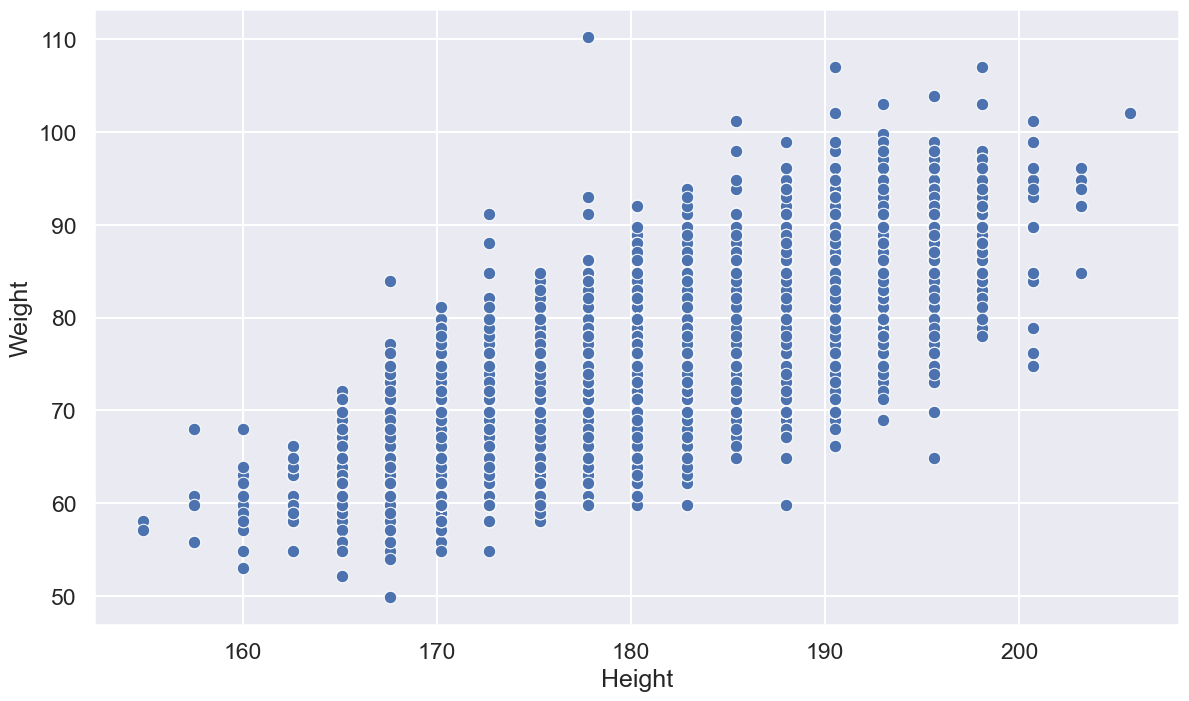

In [14]:
_ = sns.scatterplot(x='Height', y='Weight', data=df, legend=False)

### Applying DBSCAN and Exploring the Data:

In [15]:
def do_clustering(data, eps=0.5, min_samples=5):
    # We copy the data from the original dataframe and remove the player's names
    data_copy = data.copy()
    data_copy.drop(columns=['Name', 'Height', 'Weight'], inplace=True)
    
    model = DBSCAN(eps=eps, min_samples=min_samples)
    model.fit(data_copy)
    
    data_copy['cluster_labels'] = model.labels_
    data_copy['player_name'] = data['Name']
    data_copy['height'] = data['Height']
    data_copy['weight'] = data['Weight']
    
    return data_copy

In [16]:
def print_clusters(data, clusters, max_players=10):
    for c in clusters:
        print('Cluster: ', c)
        print(list(data[data['cluster_labels'] == c]['player_name'][:max_players]))
        print()
        print()

In [17]:
eps = 0.4
min_samples = 5

df_copy = do_clustering(df, eps=eps, min_samples=min_samples)
df_copy.head()

,Height_Norm,Weight_Norm,cluster_labels,player_name,height,weight
ID,,,,,,
158023,-1.659710,-0.506531,0,L. Messi,170.2,72.11
20801,0.988706,1.038073,0,Cristiano Ronaldo,188.0,82.99
190871,-0.900894,-1.085757,0,Neymar Jr,175.3,68.03
193080,1.732643,0.072695,0,De Gea,193.0,76.19
192985,-0.156957,-0.828797,0,K. De Bruyne,180.3,69.84


In [18]:
df_copy['cluster_labels'].value_counts()

 0    14975
-1       25
Name: cluster_labels, dtype: int64

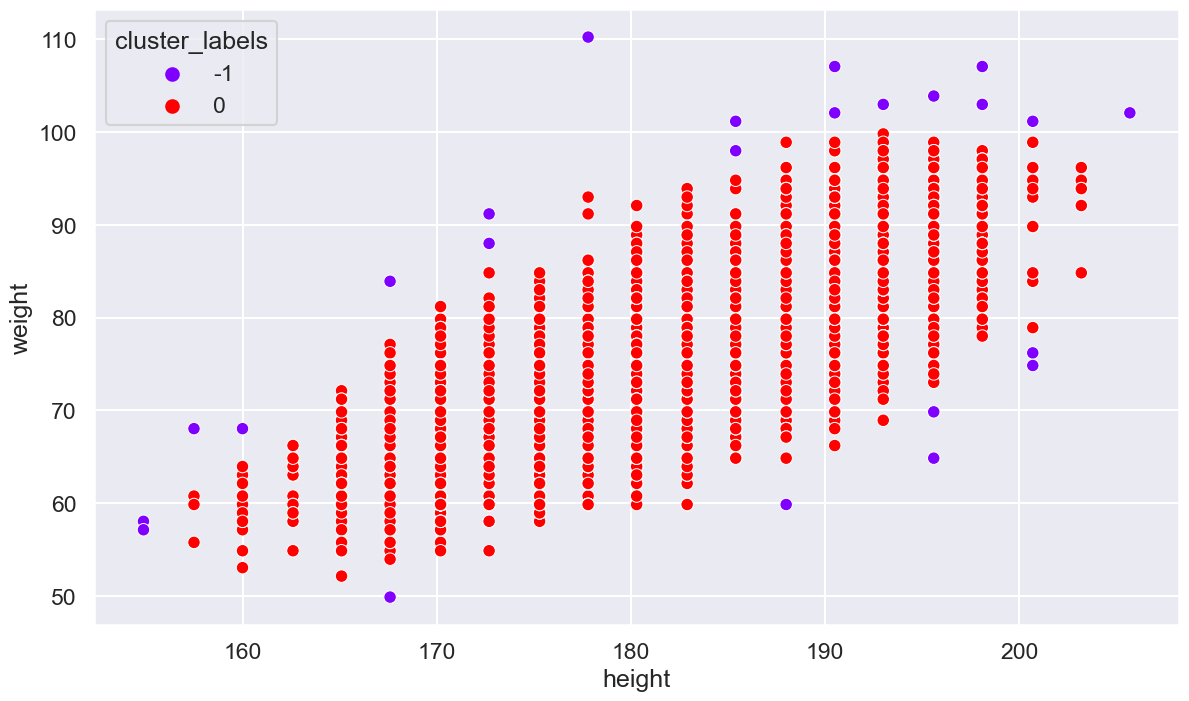

In [19]:
_ = sns.scatterplot(x='height', y='weight', data=df_copy, hue='cluster_labels', palette='rainbow')

### Rating players by height

In [20]:
df_height = df_copy.loc[df_copy['cluster_labels'] == -1][['player_name', 'height']].sort_values(by='height', ascending=False)
df_height.head()

,player_name,height
ID,,
199321,T. Holý,205.7
51257,P. Crouch,200.7
244793,T. Chorý,200.7
203841,N. Pope,200.7
199833,L. Unnerstall,198.1


In [21]:
df_height.tail()

,player_name,height
ID,,
232278,S. Mosquera,167.6
214327,V. Hernández,160.0
228404,C. Techera,157.5
232951,H. Nakagawa,154.9
237994,N. Barrios,154.9


### Rating players by Weight

In [22]:
df_weight = df_copy.loc[df_copy['cluster_labels'] == -1][['player_name', 'weight']].sort_values(by='weight', ascending=False)
df_weight.head()

,player_name,weight
ID,,
156321,A. Akinfenwa,110.20
239746,L. Watkowiak,107.03
179685,C. Seitz,107.03
195357,F. Farnolle,103.85
199833,L. Unnerstall,102.95


In [23]:
df_weight.tail()

,player_name,weight
ID,,
234049,B. Niasse,64.85
220023,A. Al Shammari,59.86
237994,N. Barrios,58.05
232951,H. Nakagawa,57.14
235600,B. Al Mutairi,49.89


## Understanding what the algorithm considers to be outliers
We can train a decision tree to predict between outlier and normal.

### Graphviz

* We are going to use graphviz (open source library for graph visualization).
* For it to work properly, you must install it accordingly and add it to your user's `path`.
* Official instructions here: https://graphviz.org/download/

In [25]:
import graphviz

In [26]:
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

### Training the DecisionTreeClassifier

In [27]:
clf = DecisionTreeClassifier(max_leaf_nodes=4)
clf.fit(df_copy[['height', 'weight']], df_copy['cluster_labels'])

DecisionTreeClassifier(max_leaf_nodes=4)

### Generating Graph

In [28]:
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=['height', 'weight'],  
                           class_names=['Outlier', 'Normal'],
                           filled=True)

### Ploting the Tree

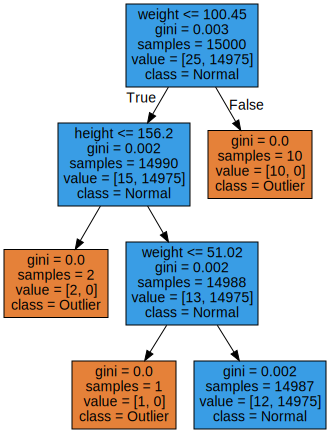

In [29]:
graph = graphviz.Source(dot_data, format="png") 
graph

# Conclusion:
As observed throughout this notebook, it is possible to verify that DBSCAN is a good algorithm for detecting outliers in an unlabeled dataset. Furthermore, the use of supervised classifiers is a good practice for explaining the outliers detected by the unsupervised algorithm (DBSCAN)